# Hodgkin-Huxley Model

The Hodgkin-Huxley (HH) model is the gold standard of biophysically detailed neuron models, fundamentally different from phenomenological models like LIF or Wilson in that it directly models the underlying ion channel dynamics responsible for action potential generation. While LIF models use abstract rules to generate spikes and Wilson models use simplified polynomial approximations, the HH model incorporates the actual nonlinear voltage-dependent conductances based on experimental measurements, making it more biologically realistic but computationally more expensive.

## Key Properties

1. **Biophysical Realism**: Models actual ion channel behavior (sodium, potassium, leak) based on experimental data
2. **Voltage-Dependent Dynamics**: Channel conductances change with membrane potential
3. **Self-Generating Action Potentials**: No explicit threshold-and-reset rule; spikes emerge naturally
4. **Refractory Period**: Natural refractory period emerges from channel dynamics
5. **Multiple Timescales**: Fast (Na+ activation), intermediate (Na+ inactivation), and slow (K+ activation) dynamics

## Mathematical Description

The model is described by four coupled differential equations:

C(dV/dt) = -gNa·m³·h·(V-ENa) - gK·n⁴·(V-EK) - gL·(V-EL) + Iext

Channel gating variables:
dm/dt = αm(V)·(1-m) - βm(V)·m
dh/dt = αh(V)·(1-h) - βh(V)·h
dn/dt = αn(V)·(1-n) - βn(V)·n

Rate constants (α and β) are voltage-dependent:
αm(V) = 0.1·(V+40)/(1-exp(-(V+40)/10))
βm(V) = 4·exp(-(V+65)/18)
αh(V) = 0.07·exp(-(V+65)/20)
βh(V) = 1/(1+exp(-(V+35)/10))
αn(V) = 0.01·(V+55)/(1-exp(-(V+55)/10))
βn(V) = 0.125·exp(-(V+65)/80)

Parameters:
- V: Membrane potential (mV)
- m: Na+ channel activation variable (0 to 1)
- h: Na+ channel inactivation variable (0 to 1)
- n: K+ channel activation variable (0 to 1)
- C: Membrane capacitance (typically 1 μF/cm²)
- gNa: Maximum sodium conductance (typically 120 mS/cm²)
- gK: Maximum potassium conductance (typically 36 mS/cm²)
- gL: Leak conductance (typically 0.3 mS/cm²)
- ENa: Sodium reversal potential (typically +50 mV)
- EK: Potassium reversal potential (typically -77 mV)
- EL: Leak reversal potential (typically -54.4 mV)
- Iext: External current input (μA/cm²)

State Variables:
- V: Membrane potential (initialize near -65 mV)
- m: Na+ activation (initialize at steady state: m∞(V))
- h: Na+ inactivation (initialize at steady state: h∞(V))
- n: K+ activation (initialize at steady state: n∞(V))

Time-related variables:
- dt: Time step for numerical integration (typically 0.01-0.1 ms)
- t: Current simulation time
- tmax: Maximum simulation time

## Algorithm

1. Initialize state variables
   - V = -65 mV (approximate resting potential)
   - m = m∞(-65) (steady-state value at rest)
   - h = h∞(-65) (steady-state value at rest)
   - n = n∞(-65) (steady-state value at rest)
   - Create empty lists for recording variables

2. For each time step from t=0 to t=tmax:
   
   a. Compute rate constants based on current voltage
      - Calculate αm(V), βm(V), αh(V), βh(V), αn(V), βn(V)
   
   b. Compute derivative terms
      - dV/dt = (-gNa·m³·h·(V-ENa) - gK·n⁴·(V-EK) - gL·(V-EL) + Iext) / C
      - dm/dt = αm(V)·(1-m) - βm(V)·m
      - dh/dt = αh(V)·(1-h) - βh(V)·h
      - dn/dt = αn(V)·(1-n) - βn(V)·n
   
   c. Update state variables using numerical integration
      - V = V + dV/dt · dt
      - m = m + dm/dt · dt
      - h = h + dh/dt · dt
      - n = n + dn/dt · dt
   
   d. Store variables for plotting
      - Record V, m, h, n at current time step
   
   e. Increment time: t = t + dt

3. Analyze and visualize results
   - Plot membrane potential (V) vs time
   - Plot gating variables (m, h, n) vs time
   - Plot channel conductances (gNa·m³·h, gK·n⁴) vs time
   - Calculate action potential properties (amplitude, duration, threshold)
   - Analyze firing rate in response to different current stimuli

## Characteristic Behaviors

1. **Action Potential**: Rapid depolarization followed by repolarization and afterhyperpolarization
2. **Threshold Behavior**: Stimuli below threshold produce subthreshold responses; above threshold generate spikes
3. **Refractory Period**: Reduced excitability immediately following an action potential
4. **Frequency-Current Relationship**: Firing rate increases with input current strength
5. **Adaptation**: Firing rate can decrease during sustained stimulation
6. **Resonance**: Preferential response to inputs at specific frequencies
7. **Excitability Changes**: Threshold can be modified by prior activity or channel modulation

## Biological Mechanisms Represented

- **Na+ Channels** (m³h): Fast activation (m) and slower inactivation (h) responsible for the upstroke
- **K+ Channels** (n⁴): Voltage-dependent activation (n) responsible for repolarization
- **Leak Channels**: Passive conductance establishing the resting potential
- **Membrane Capacitance**: Responsible for integrating currents and determining time course
- **Ion Reversal Potentials**: Determined by concentration gradients across the membrane

## Applications

The Hodgkin-Huxley model is particularly useful for:
- Studying the biophysical basis of neuronal excitability
- Investigating effects of ion channel mutations or pharmacological agents
- Understanding complex firing patterns in different neuron types
- Modeling neurological disorders involving channelopathies
- Developing more accurate multi-compartment models of neurons
- Validating simplified neuron models against a biophysical standard
- Educational purposes to demonstrate action potential generation mechanisms

### Implementation

In [11]:
import numpy as np
# 1. Computing voltage dependant params
class Classic_HH:
    def __init__(self, 
                 Cm=1.0,                # Membrane capacitance (μF/cm²)
                 g_Na=120.0,            # Maximum sodium conductance (mS/cm²)
                 g_K=36.0,              # Maximum potassium conductance (mS/cm²)
                 g_L=0.3,               # Leak conductance (mS/cm²)
                 E_Na=50.0,             # Sodium reversal potential (mV)
                 E_K=-77.0,             # Potassium reversal potential (mV)
                 E_L=-54.4,             # Leak reversal potential (mV)
                 V_rest=-65.0):         # Resting membrane potential (mV)
        
        # Membrane properties
        self.Cm = Cm
        self.g_Na = g_Na
        self.g_K = g_K
        self.g_L = g_L
        self.E_Na = E_Na
        self.E_K = E_K
        self.E_L = E_L
        
        # State variables
        self.V = V_rest
        
        # Initialize gating variables to steady-state values at resting potential
        self.m = self.m_inf(V_rest)
        self.h = self.h_inf(V_rest)
        self.n = self.n_inf(V_rest)
    
    # Voltage-dependent rate constants for sodium activation (m)
    def alpha_m(self, V):
        return 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))
    
    def beta_m(self, V):
        return 4.0 * np.exp(-(V + 65) / 18)
    
    # Voltage-dependent rate constants for sodium inactivation (h)
    def alpha_h(self, V):
        return 0.07 * np.exp(-(V + 65) / 20)
    
    def beta_h(self, V):
        return 1.0 / (1 + np.exp(-(V + 35) / 10))
    
    # Voltage-dependent rate constants for potassium activation (n)
    def alpha_n(self, V):
        return 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10))
    
    def beta_n(self, V):
        return 0.125 * np.exp(-(V + 65) / 80)
    
    # Steady-state values for gating variables
    def m_inf(self, V):
        alpha = self.alpha_m(V)
        beta = self.beta_m(V)
        return alpha / (alpha + beta)
    
    def h_inf(self, V):
        alpha = self.alpha_h(V)
        beta = self.beta_h(V)
        return alpha / (alpha + beta)
    
    def n_inf(self, V):
        alpha = self.alpha_n(V)
        beta = self.beta_n(V)
        return alpha / (alpha + beta)
    
    # Time constants for gating variables
    def tau_m(self, V):
        alpha = self.alpha_m(V)
        beta = self.beta_m(V)
        return 1.0 / (alpha + beta)
    
    def tau_h(self, V):
        alpha = self.alpha_h(V)
        beta = self.beta_h(V)
        return 1.0 / (alpha + beta)
    
    def tau_n(self, V):
        alpha = self.alpha_n(V)
        beta = self.beta_n(V)
        return 1.0 / (alpha + beta)
    
    # Ionic currents
    def I_Na(self, V, m, h):
        return self.g_Na * m**3 * h * (V - self.E_Na)
    
    def I_K(self, V, n):
        return self.g_K * n**4 * (V - self.E_K)
    
    def I_L(self, V):
        return self.g_L * (V - self.E_L)
    
    # Derivatives of state variables
    def dVdt(self, V, m, h, n, I_ext=0.0):
        I_Na = self.I_Na(V, m, h)
        I_K = self.I_K(V, n)
        I_L = self.I_L(V)
        return (I_ext - I_Na - I_K - I_L) / self.Cm
    
    def dmdt(self, V, m):
        return self.alpha_m(V) * (1 - m) - self.beta_m(V) * m
    
    def dhdt(self, V, h):
        return self.alpha_h(V) * (1 - h) - self.beta_h(V) * h
    
    def dndt(self, V, n):
        return self.alpha_n(V) * (1 - n) - self.beta_n(V) * n
    
    # Update state variables using Euler method
    def update(self, dt, I_ext=0.0):
        # Calculate derivatives
        dV = self.dVdt(self.V, self.m, self.h, self.n, I_ext) * dt
        dm = self.dmdt(self.V, self.m) * dt
        dh = self.dhdt(self.V, self.h) * dt
        dn = self.dndt(self.V, self.n) * dt
        
        # Update state variables
        self.V += dV
        self.m += dm
        self.h += dh
        self.n += dn
        
        return self.V, self.m, self.h, self.n
    
    # Run simulation for a given time with specified stimulus
    def simulate(self, t_max, dt, I_ext_func=None):
        """
        Run the simulation for t_max milliseconds with time step dt.
        
        Parameters:
        -----------
        t_max : float
            Maximum simulation time in milliseconds
        dt : float
            Time step for numerical integration in milliseconds
        I_ext_func : callable, optional
            Function that takes time as input and returns external current
            
        Returns:
        --------
        tuple
            (time_points, V, m, h, n) arrays containing simulation results
        """
        n_steps = int(t_max / dt)
        time_points = np.arange(0, t_max, dt)
        
        # Arrays to store results
        V_trace = np.zeros(n_steps)
        m_trace = np.zeros(n_steps)
        h_trace = np.zeros(n_steps)
        n_trace = np.zeros(n_steps)
        
        # Initial values
        V_trace[0] = self.V
        m_trace[0] = self.m
        h_trace[0] = self.h
        n_trace[0] = self.n
        
        # Simulation loop
        for i in range(1, n_steps):
            t = time_points[i]
            I_ext = I_ext_func(t) if I_ext_func is not None else 0.0
            
            # Update state variables
            V, m, h, n = self.update(dt, I_ext)
            
            # Store results
            V_trace[i] = V
            m_trace[i] = m
            h_trace[i] = h
            n_trace[i] = n
        
        return time_points, V_trace, m_trace, h_trace, n_trace

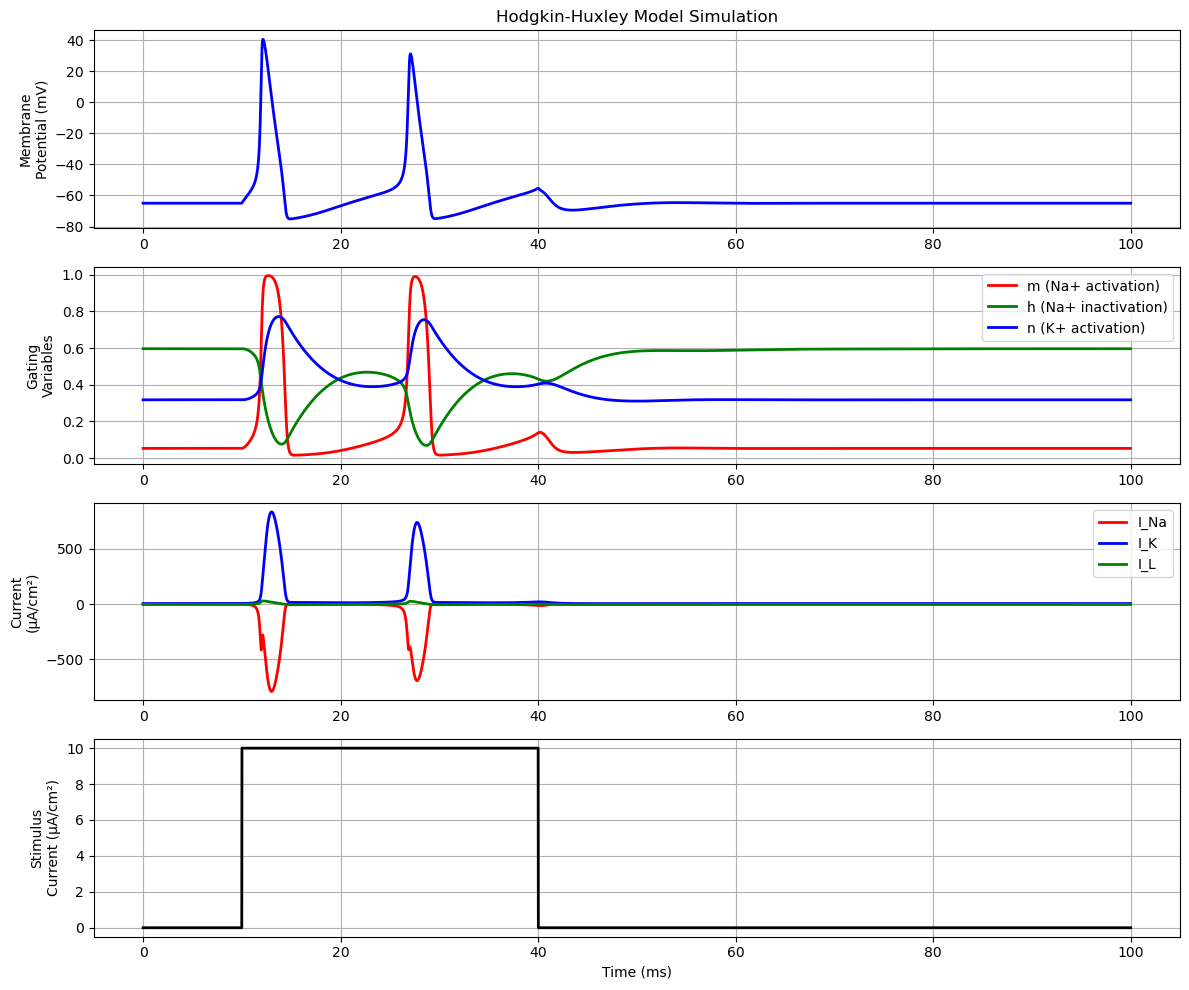

Resting Membrane Potential: -65.00 mV
Action Potential Peak: 40.54 mV
Action Potential Amplitude: 105.54 mV


In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Create an instance of our Hodgkin-Huxley model
hh = Classic_HH()

# Define a step current stimulus function
def step_current(t):
    # Apply a 10 μA/cm² current from t=10ms to t=40ms
    if 10 <= t <= 40:
        return 10.0
    return 0.0

# Run the simulation
t_max = 100  # Maximum simulation time (ms)
dt = 0.01    # Time step for integration (ms)
time, V, m, h, n = hh.simulate(t_max, dt, I_ext_func=step_current)

# Calculate the currents for plotting
I_Na = np.zeros_like(time)
I_K = np.zeros_like(time)
I_L = np.zeros_like(time)
I_stim = np.zeros_like(time)

for i in range(len(time)):
    I_Na[i] = hh.I_Na(V[i], m[i], h[i])
    I_K[i] = hh.I_K(V[i], n[i])
    I_L[i] = hh.I_L(V[i])
    I_stim[i] = step_current(time[i])

# Create a figure with multiple subplots
plt.figure(figsize=(12, 10))

# Plot 1: Membrane potential
plt.subplot(4, 1, 1)
plt.plot(time, V, 'b', linewidth=2)
plt.title('Hodgkin-Huxley Model Simulation')
plt.ylabel('Membrane\nPotential (mV)')
plt.grid(True)

# Plot 2: Gating variables
plt.subplot(4, 1, 2)
plt.plot(time, m, 'r', label='m (Na+ activation)', linewidth=2)
plt.plot(time, h, 'g', label='h (Na+ inactivation)', linewidth=2)
plt.plot(time, n, 'b', label='n (K+ activation)', linewidth=2)
plt.ylabel('Gating\nVariables')
plt.legend(loc='upper right')
plt.grid(True)

# Plot 3: Ionic currents
plt.subplot(4, 1, 3)
plt.plot(time, I_Na, 'r', label='I_Na', linewidth=2)
plt.plot(time, I_K, 'b', label='I_K', linewidth=2)
plt.plot(time, I_L, 'g', label='I_L', linewidth=2)
plt.ylabel('Current\n(μA/cm²)')
plt.legend(loc='upper right')
plt.grid(True)

# Plot 4: Stimulus current
plt.subplot(4, 1, 4)
plt.plot(time, I_stim, 'k', linewidth=2)
plt.xlabel('Time (ms)')
plt.ylabel('Stimulus\nCurrent (μA/cm²)')
plt.grid(True)

plt.tight_layout()
plt.show()

# Display some key metrics
action_potential_peak = np.max(V)
resting_potential = V[0]
print(f"Resting Membrane Potential: {resting_potential:.2f} mV")
print(f"Action Potential Peak: {action_potential_peak:.2f} mV")
print(f"Action Potential Amplitude: {action_potential_peak - resting_potential:.2f} mV")